# "Evaluamos" la opción de Flagging and Correction

Se evaluará el comportamiento del algoritmo Flagging and Correction que usa Rainview Analyzer para filtrar los datos del radar. Este se basa en la identificación de elementos a lo largo del eje radial para ser interpolados. Si son marcados, se interpola. 
La interpolación es bilineal si el próximo valor disponible está cerca del eje radial y azimuth, o en solo uno de los ejes si el próximo valor disponible está cerca solo en una dirección. 

Para el binarizado se usan ventanas en la dirección radial, cuyo tamaño varía con cierta fórmula. Pese a que esta se encuentra en la documentación, los parámetros no son lo suficientemente explicitos para poder programarla(o al menos yo no los entiendo.) En su lugar usaremos una ventana fija de 7 elementos radiales (las ventanas más largas se encontrarán en las cercanías mientras que para las lejanías el tamaño de ventana importa mucho menos). 

In [2]:
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import skimage
import warnings 

import utilidades as util

from skimage.morphology import disk

warnings.filterwarnings('ignore')

Los primeros pasos de este procedimiento son los mismos que aquellos realizados para el método Subtraction descrito antes.

In [3]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)
Matriz = util.matriz3d(clutterdata)
azi, r = util.ejes()
Clutter_max = np.max(Matriz, axis=2)

In [4]:
selem = np.ones(shape=(3,3))
local_max = util.maximum(Clutter_max, selem)

In [5]:
Cadj = 1 
Cluttermap = local_max + Cadj

Luego corresponde una segmentación radial de acuerdo al tamaño de la ventana, que evita interpolaciones de pequeños segmentos de clutter que hallan sobrepasado el umbral. Para ello necesitaremos binarizar los datos.

In [6]:
def binary(data,cluttermap):
    tmp = ~(data >= cluttermap)
    tmp = tmp * (cluttermap > cluttermap.min()) * (data > data.min())
    return tmp.astype(int)

Luego del binarizado, es momento de utilizar las ventanas para realizar el marcado realmente.

In [7]:
def flagging(binimg, wsize=7):
    tmp = binimg.astype(int)
    shape = binimg.shape
    element = wsize // 2
    shift = range(-element,element+1)
    range_shift = range(element,shape[1]-wsize,wsize)
    count = np.zeros_like(tmp)
    for i in range_shift :
        little = np.array(shift) + i
        for j in shift:
            ref = np.roll(tmp, j , axis=1)
            count[:,little] = count[:,little] + ref[:,little]
    return count

Veamos los resultados parciales usando el conjunto de ejemplo.

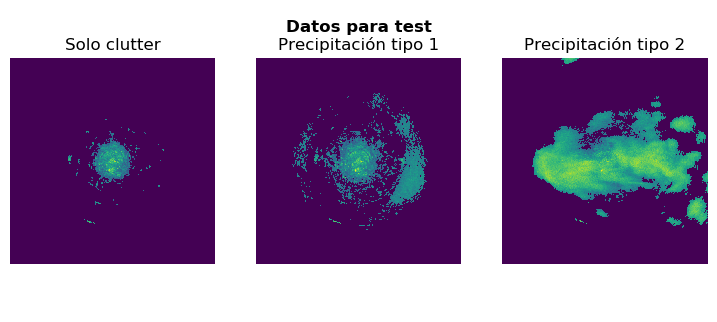

In [8]:
data, titles = util.testeo(explore=True, rmax=20)

In [9]:
binarizado = []
flags = []
for dato in data:
    tmp = binary(dato,Cluttermap)
    binarizado.append(tmp)
    flags.append(flagging(tmp, wsize=7))

Vemos los resultados del binarizado

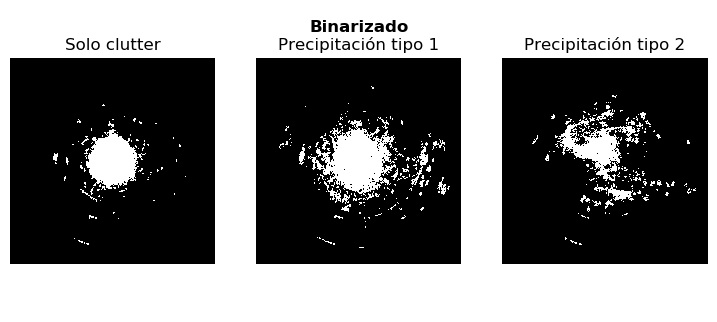

In [10]:
util.testeo_results(cluttermaps=None, results=binarizado, rmax=15, title2='Binarizado', cmap=plt.cm.gray)

Y los del marcado ...

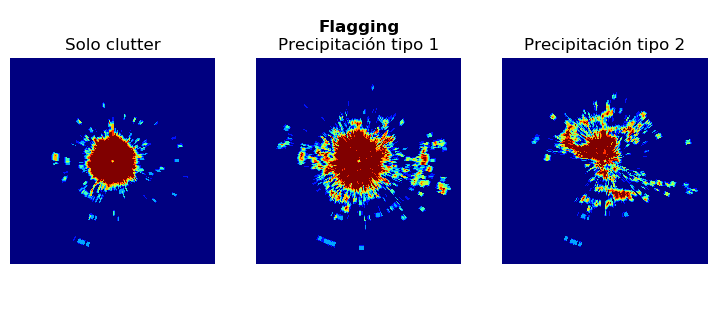

In [11]:
util.testeo_results(cluttermaps=None, results=flags, rmax=15, title2='Flagging', cmap=plt.cm.jet, vmin=0, vmax=7)

Marcamos aquellas celdas dentro que han superado la mitad del tamaño de la ventana. 

In [12]:
def mark(flag, cluttermap, Cadj=1, wsize=7):
    element = (wsize + 1) /2
    relmark = flag > element
    return relmark 

In [13]:
marks = [mark(flag, Cluttermap, wsize=7) for flag in flags]

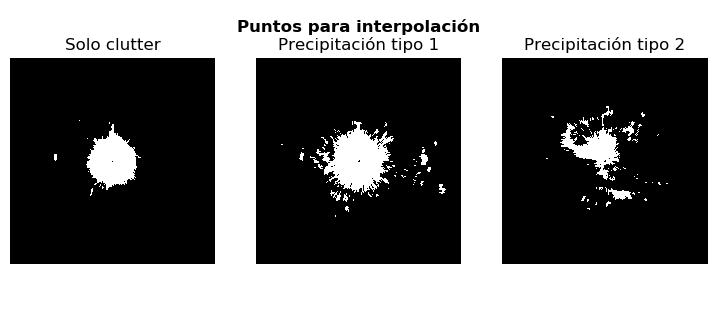

In [14]:
util.testeo_results(cluttermaps=None, results=marks, rmax=15, title2='Puntos para interpolación', cmap=plt.cm.gray)

Rainview Analyzer para evitar la interpolación mediante puntos no representativos solo realiza la interpolación cuando los vecinos más cercanos se encuentran dentro de ciertos límites.  Las condiciones para realizar la interpolación comprenden  una distancia máxima de selección radial, una distancia máxima de selección azimutal y un ángulo máximo de 45° de diferencia azimutal. Dependiendo de las condiciones los puntos se interpolan en dirección radial, azimutal o ambas. Los puntos que no cumplen ninguna condición son puestos bajo la opción de No Data.

En el presente cuaderno no se evaluará la condición radial, principalmente porque no es importante para distancias pequeñas donde primará la restricción angular.

In [15]:
def valid_radial(binimg, size_meters=2000):
    tmp = binimg.copy().astype(int)
    element = int(size_meters / (100 * 2)) # Radar resolution
    shift = range(-element, element + 1)
    count = np.zeros_like(binimg)
    for i in shift:
        ref = np.roll(tmp, i, axis=1)
        count = count + ref
    result = (count < 2 * element - 2) * binimg
    return result

In [16]:
radial = [valid_radial(marka) for marka in marks]

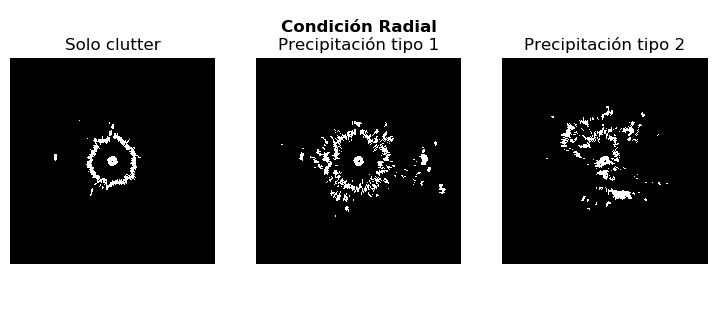

In [17]:
util.testeo_results(cluttermaps=None, results=radial, rmax=15, title2='Condición Radial', cmap=plt.cm.gray)

In [18]:
def valid_azi(binimg, valid=45):
    tmp = binimg.copy().astype(int)
    element = valid // 2 
    shift = range(-element, element + 1)
    count = np.zeros_like(binimg)
    for i in shift:
        ref = np.roll(tmp, i, axis=0)
        count = count + ref
    result = count > 2 * element - 2
    return ~result * binimg

In [19]:
azi = [valid_azi(marka) for marka in marks]

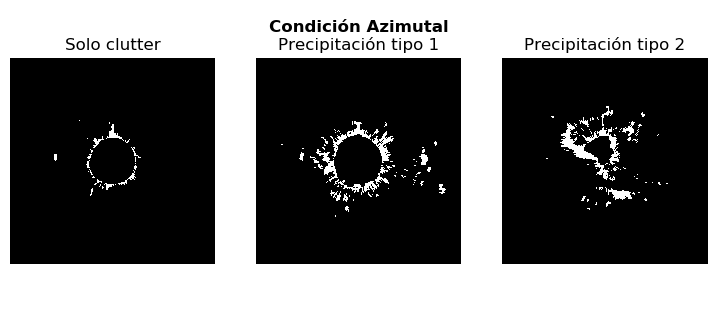

In [20]:
util.testeo_results(cluttermaps=None, results=azi, rmax=15, title2='Condición Azimutal', cmap=plt.cm.gray)

A partir de estos resultados se definen las zonas para cada tipo de interpolación.

In [21]:
ipoldoble = [radial[x] * azi[x] for x in range(len(radial))]
ipolrad = [radial[x] * ~ azi[x] for x in range(len(radial))]
ipolazi = [~ radial[x] * azi[x] for x in range(len(radial))]

Mostramos cada zona de interpolación:

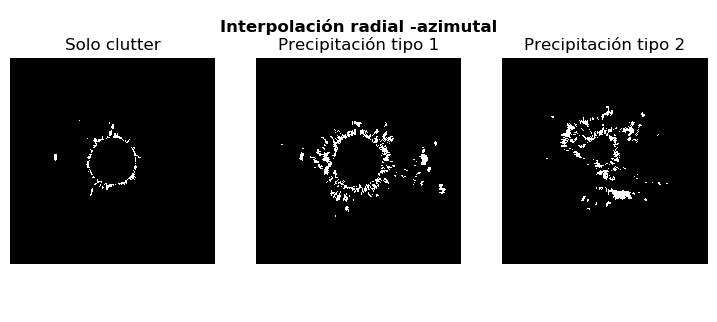

In [22]:
util.testeo_results(cluttermaps=None, results=ipoldoble, rmax=15, title2='Interpolación radial -azimutal', cmap=plt.cm.gray)

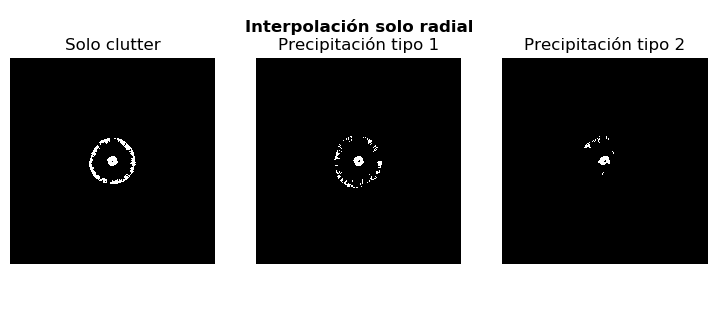

In [23]:
util.testeo_results(cluttermaps=None, results=ipolrad, rmax=15, title2='Interpolación solo radial', cmap=plt.cm.gray)

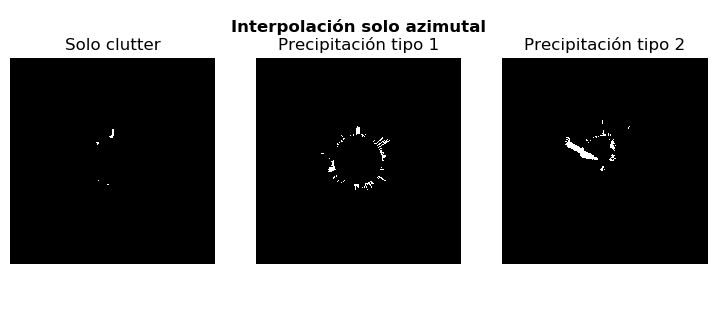

In [24]:
util.testeo_results(cluttermaps=None, results=ipolazi, rmax=15, title2='Interpolación solo azimutal', cmap=plt.cm.gray)

Con cada zona ya mapeada solo basta con realizar la interpolación correspondiente. Fácil no? Pues no si no conoces los métodos de interpolación, sus características y las ventajas/desventajas de cada método de interpolación no lo podrás hacer. Por ello, antes de terminar esta evaluación veremos las diferentes aproximaciones de interpolación. 